In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import time

# Check for GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Set all seeds

In [3]:
import torch
import random
import numpy as np

SEED = 2022

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Hyperparams

In [4]:
LR = 1e-3 # learning rate
NUM_ITER = 3000 # number iterations

NZ = 512 # input seed dimension
NGF = 128 # number of filters per layer

BS = 1 #batch size
NC = 2 # number of channels

# Grab the data

In [5]:
x_labels = torch.load("/scratch/04703/sravula/UTAFSDataNew/FREQ_VALS.pt")
x_raw = torch.load("/scratch/04703/sravula/UTAFSDataNew/X_RAW.pt")

In [6]:
print(len(x_labels))
print(x_labels[0].shape)

print(len(x_raw))
print(x_raw[0].shape)

1406
torch.Size([1000])
1406
torch.Size([1000, 10, 2])


In [7]:
min_arr = [torch.min(t).item() for t in x_raw]
max_arr = [torch.max(t).item() for t in x_raw]

print("MIN VAL: ", np.min(min_arr))
print("MAX VAL: ", np.max(max_arr))

MIN VAL:  -0.9739965796470642
MAX VAL:  0.9999977946281433


## Looks like there's no need to normalize the data further....

In [8]:
def get_single_series(data, sample_num, chip_num, num_chan):
    """
    Grabs the Real or (Real, Im) series for a single sample and a single chip.
    Output shape is (1, num_chan, L)
    """
    x = data[sample_num][:, chip_num, :] #(LEN, 2)
    
    if num_chan == 1:
        x = x[:, 0].unsqueeze(1) #(LEN, 1)
    
    x = x.unsqueeze(0) #(1, LEN, 1/2)
    x = x.permute(0, 2, 1) #(1, 1/2, LEN)
    
    return x

SAMPLE_IDX = 50
CHIP_IDX = 2

x = get_single_series(x_raw, SAMPLE_IDX, CHIP_IDX, NC)

print(x.shape)

torch.Size([1, 2, 9998])


In [9]:
def get_inds(problem_type, length, num_kept_samples):
    """Given a number of samples to keep and a problem type, returns indices to keep from a list"""
    if problem_type=="random":
        kept_inds = np.random.choice(length, num_kept_samples, replace=False)
    elif problem_type=="equal":
        kept_inds = np.arange(0, length, (length // num_kept_samples))
    elif problem_type=="forecast":
        kept_inds = np.arange(0, num_kept_samples)
    else:
        raise NotImplementedError("THIS PROBLEM TYPE IS UNSUPPORTED")
    
    missing_inds = np.array([t for t in range(length) if t not in kept_inds])
    
    return np.sort(kept_inds), np.sort(missing_inds)

In [10]:
PROBLEM_TYPE = "equal" #[random, equal, forecast]
LENGTH = x.shape[-1]
M = 100

kept_inds, missing_inds = get_inds(PROBLEM_TYPE, LENGTH, M)
M = len(kept_inds)

In [11]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

9998
101
101
9897


In [12]:
y = torch.clone(x)[:, :, kept_inds]

print(y.shape)

torch.Size([1, 2, 101])


# Visualize the data and the observations

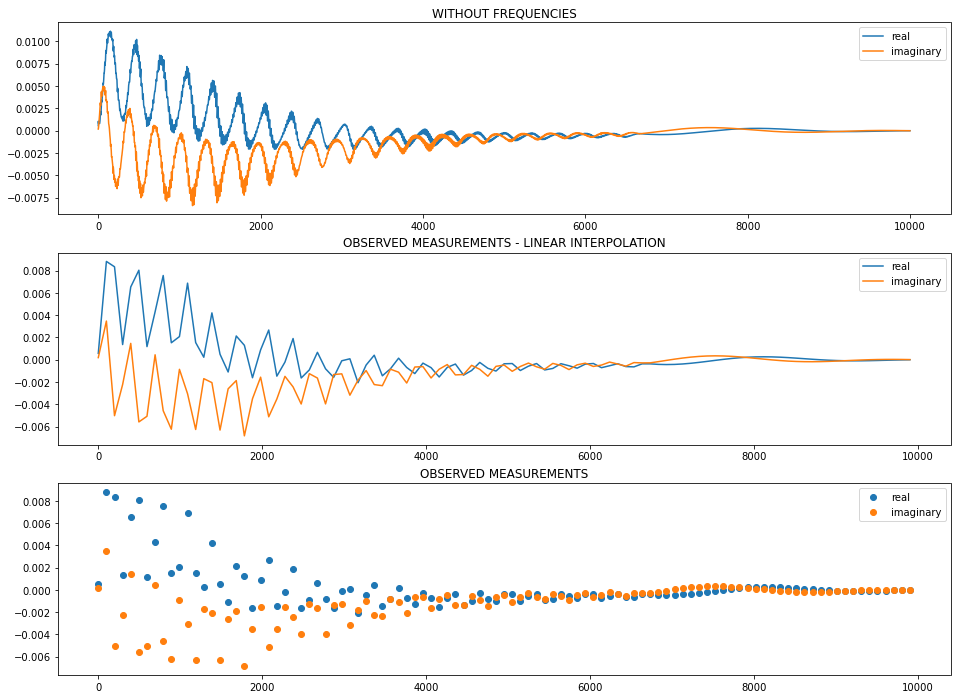

In [13]:
for i in range(BS):
    fig, axes = plt.subplots(3,1, figsize=(16, 12))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("WITHOUT FREQUENCIES")

    axes[1].plot(kept_inds, y[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[1].plot(kept_inds, y[i,1,:].flatten(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("OBSERVED MEASUREMENTS - LINEAR INTERPOLATION")

    axes[2].scatter(kept_inds, y[i,0,:].flatten(), label="real")
    if NC == 2:
        axes[2].scatter(kept_inds, y[i,1,:].flatten(), label="imaginary")
    axes[2].legend()
    axes[2].set_title("OBSERVED MEASUREMENTS")

    plt.show()

# Pad

In [14]:
PADDED_LEN = 2**int(np.ceil(np.log2(LENGTH)))
print(PADDED_LEN)

16384


In [15]:
DIFF = (PADDED_LEN - LENGTH)
L_PAD, R_PAD = DIFF // 2, DIFF - DIFF // 2
print(L_PAD)
print(R_PAD)
print(LENGTH)
print(PADDED_LEN - L_PAD - R_PAD)

3193
3193
9998
9998


In [16]:
kept_inds = [k + L_PAD for k in kept_inds]
print(len(kept_inds))

101


# Set up the network

In [17]:
from models import DCGAN, UNET, ENC_DEC, MULTISCALE_ENC_DEC

net = ENC_DEC(bs=BS, nz=NZ, ngf=NGF, output_size=PADDED_LEN, nc=NC)
# net = MULTISCALE_ENC_DEC(bs=BS, nz=NZ, ngf=NGF, output_size=PADDED_LEN, nc=NC)
net = net.to(device)

In [18]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 2, 16384])


In [19]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  189305856


## Set up and run experiment

In [20]:
from pytorch_wavelets import DWT1DForward
import pywt

class Wavelet_MSE_Loss(nn.Module):
    def __init__(self, out_length, kept_inds, wavelet, alpha, device):
        super().__init__()
        
        self.kept_inds = kept_inds
        self.alpha = alpha
        
        self.mse_loss = nn.MSELoss().to(device)
        
        w = pywt.Wavelet(wavelet)
        maxlev = pywt.dwt_max_level(out_length, w.dec_len)
        
        self.dwt = DWT1DForward(J=maxlev, wave=wavelet).to(device)
    
    def forward(self, x, y):
        mse = self.mse_loss(x[:, :, self.kept_inds], y)
        
        wl, wh = self.dwt(x)
        wavelet_coeffs = torch.sum(torch.abs(wl))
        for i in range(len(wh)):
            wavelet_coeffs += torch.sum(torch.abs(wh[i]))
        
        return mse + self.alpha*wavelet_coeffs

In [21]:
WAVELET = 'sym4'
ALPHA_REG = 1.0e-7

LOSS_TYPE = "mse"

if LOSS_TYPE=="mse":
    criterion = lambda x, y: nn.MSELoss()(x[:, :, kept_inds], y)
elif LOSS_TYPE=="mse_wavelet":
    criterion = Wavelet_MSE_Loss(LENGTH, kept_inds, WAVELET, ALPHA_REG, device)

In [22]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_mses = []
test_maes = []
outputs = []

x = x.to(device)
y = y.to(device)

In [23]:
import copy

tic = time.time()
for i in range(NUM_ITER):
    net.perturb_noise(0.05) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        out = out[..., L_PAD:-R_PAD]
        
        outputs.append(out.detach().clone().cpu())
        train_losses.append(train_loss.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%100 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

ITER  0
TIME:  0.15013623237609863

ITER  99
TIME:  8.81203293800354

ITER  199
TIME:  17.563581466674805

ITER  299
TIME:  26.313812017440796

ITER  399
TIME:  35.07528614997864

ITER  499
TIME:  43.883068561553955

ITER  599
TIME:  52.690359354019165

ITER  699
TIME:  61.49595594406128

ITER  799
TIME:  70.29815220832825

ITER  899
TIME:  79.09769344329834

ITER  999
TIME:  87.89678001403809

ITER  1099
TIME:  96.69203901290894

ITER  1199
TIME:  105.49704003334045

ITER  1299
TIME:  114.30829644203186

ITER  1399
TIME:  123.11676788330078

ITER  1499
TIME:  131.9261384010315

ITER  1599
TIME:  140.73821330070496

ITER  1699
TIME:  149.54629755020142

ITER  1799
TIME:  158.35431623458862

ITER  1899
TIME:  167.17834091186523

ITER  1999
TIME:  175.9918143749237

ITER  2099
TIME:  184.80152034759521

ITER  2199
TIME:  193.6131899356842

ITER  2299
TIME:  202.42745161056519

ITER  2399
TIME:  211.23921942710876

ITER  2499
TIME:  220.04944324493408

ITER  2599
TIME:  228.86455535888672

## Plot the final and best outputs

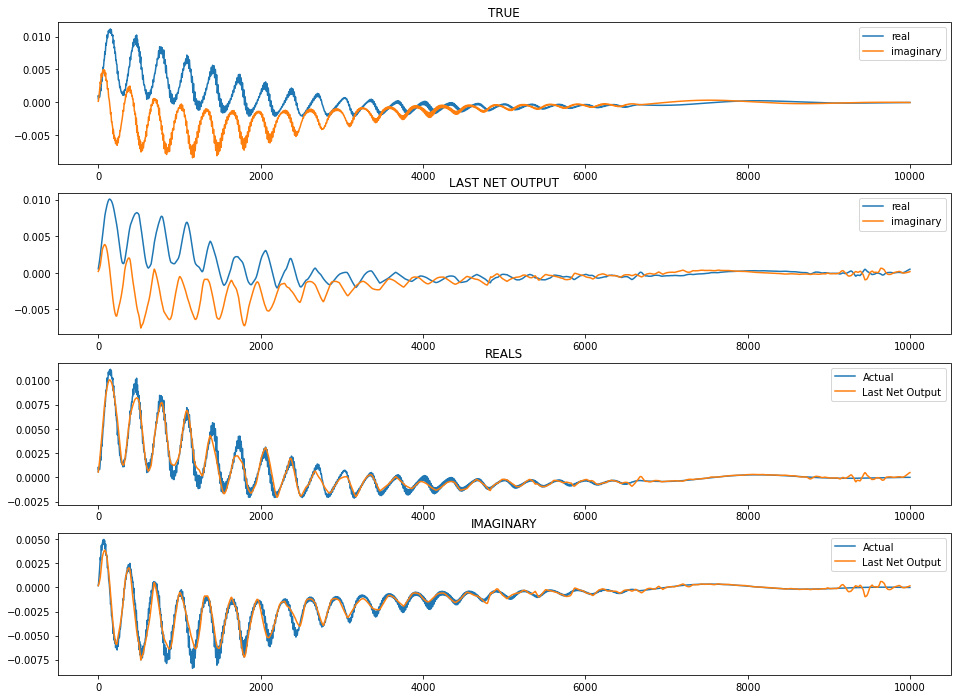

In [24]:
out_last = outputs[-1]

for i in range(BS):
    fig, axes = plt.subplots(NC+2,1, figsize=(16, 12))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("TRUE")

    axes[1].plot(out_last[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[1].plot(out_last[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("LAST NET OUTPUT")

    axes[2].plot(x[i,0,:].flatten().detach().cpu(), label="Actual")
    axes[2].plot(out_last[i,0,:].flatten().detach().cpu(), label="Last Net Output")
    axes[2].legend()
    axes[2].set_title("REALS")

    if NC == 2:
        axes[3].plot(x[i,1,:].flatten().detach().cpu(), label="Actual")
        axes[3].plot(out_last[i,1,:].flatten().detach().cpu(), label="Last Net Output")
        axes[3].legend()
        axes[3].set_title("IMAGINARY")

    plt.show()

BEST TRAIN ITER:  2998


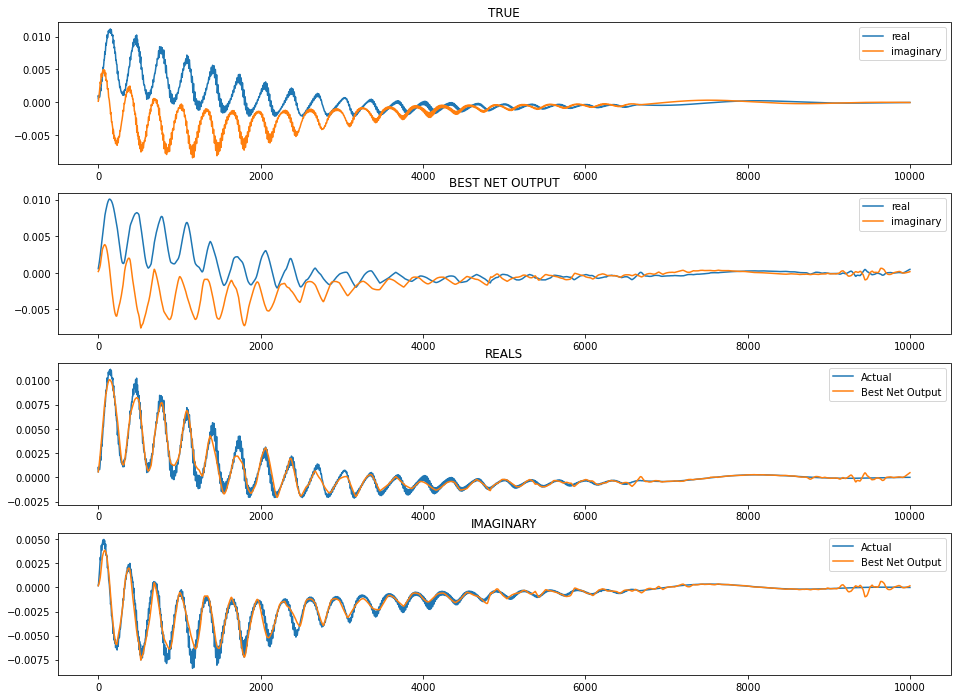

In [25]:
out_best = outputs[np.argmin(train_losses)]
print("BEST TRAIN ITER: ", np.argmin(train_losses))

for i in range(BS):
    fig, axes = plt.subplots(NC+2,1, figsize=(16, 12))
    axes = axes.flatten()

    axes[0].plot(x[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[0].plot(x[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[0].legend()
    axes[0].set_title("TRUE")

    axes[1].plot(out_best[i,0,:].flatten().detach().cpu(), label="real")
    if NC == 2:
        axes[1].plot(out_best[i,1,:].flatten().detach().cpu(), label="imaginary")
    axes[1].legend()
    axes[1].set_title("BEST NET OUTPUT")

    axes[2].plot(x[i,0,:].flatten().detach().cpu(), label="Actual")
    axes[2].plot(out_best[i,0,:].flatten().detach().cpu(), label="Best Net Output")
    axes[2].legend()
    axes[2].set_title("REALS")

    if NC == 2:
        axes[3].plot(x[i,1,:].flatten().detach().cpu(), label="Actual")
        axes[3].plot(out_best[i,1,:].flatten().detach().cpu(), label="Best Net Output")
        axes[3].legend()
        axes[3].set_title("IMAGINARY")

    plt.show()

# METRICS

In [ ]:
from dtw import *

tic = time.time()

dtw_list_re = []
if NC == 2:
    dtw_list_im = []
    
for sig in outputs:
    l_dtw_re = dtw(x[0,0,:].flatten().detach().cpu().numpy(), sig[0,0,:].flatten().detach().cpu().numpy(), distance_only=True)
    dtw_list_re.append(l_dtw_re.distance)
    if NC == 2:
        l_dtw_im = dtw(x[0,1,:].flatten().detach().cpu().numpy(), sig[0,1,:].flatten().detach().cpu().numpy(), distance_only=True)
        dtw_list_im.append(l_dtw_im.distance)

toc = time.time()
print("TIME: ", str(toc - tic))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., 0.00001)
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("MSE")
plt.ylim(0., 0.01)
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("MAE")
plt.ylim(0.04, 0.1)
plt.show()

plt.figure()
plt.plot(dtw_list_re, color='m')
plt.title("DTW REAL")
plt.ylim(20, 50)
plt.show()

if NC == 2:
    plt.figure()
    plt.plot(dtw_list_im)
    plt.title("DTW IMAGINARY")
    plt.ylim(20, 50)
    plt.show()

In [ ]:
print("BEST TRAIN LOSS (IDX, VAL): ", np.argmin(train_losses), np.min(train_losses))
print("LAST TRAIN LOSS (VAL): ", train_losses[-1])
print()

print("BEST MSE (IDX, VAL): ", np.argmin(test_mses), np.min(test_mses))
print("LAST MSE (VAL): ", test_mses[-1])
print("TRAIN BEST MSE (VAL): ", test_mses[np.argmin(train_losses)])
print()

print("BEST MAE (IDX, VAL): ", np.argmin(test_maes), np.min(test_maes))
print("LAST MAE (VAL): ", test_maes[-1])
print("TRAIN BEST MAE (VAL): ", test_maes[np.argmin(train_losses)])
print()

print("BEST REAL DTW (IDX, VAL): ", np.argmin(dtw_list_re), np.min(dtw_list_re))
print("LAST REAL DTW (VAL): ", dtw_list_re[-1])
print("TRAIN BEST REAL DTW (VAL): ", dtw_list_re[np.argmin(train_losses)])
print()

if NC==2:
    print("BEST IM DTW (IDX, VAL): ", np.argmin(dtw_list_im), np.min(dtw_list_im))
    print("LAST IM DTW (VAL): ", dtw_list_im[-1])
    print("TRAIN BEST IM DTW (VAL): ", dtw_list_im[np.argmin(train_losses)])

## Calculate the linear interpolation for comparison

In [ ]:
#make kept_inds the original value
kept_inds = [k - L_PAD for k in kept_inds]

In [ ]:
x_int_re = np.interp(np.arange(LENGTH), kept_inds, y[0,0,:].detach().cpu().flatten())
if NC == 2:
    x_int_im = np.interp(np.arange(LENGTH), kept_inds, y[0,1,:].detach().cpu().flatten())

plt.figure(figsize=(12,6))
plt.plot(x_int_re, label="Interpolation")
plt.plot(x[0,0,:].detach().cpu(), label="Real")
plt.legend()
plt.title("Linear interpolation vs Real")
plt.show()

if NC == 2:
    plt.figure(figsize=(12,6))
    plt.plot(x_int_im, label="Interpolation")
    plt.plot(x[0,1,:].detach().cpu(), label="Imaginary")
    plt.legend()
    plt.title("Linear interpolation vs Imaginary")
    plt.show()

## MSE Comparison

In [ ]:
if NC == 2:
    sse_re = nn.MSELoss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    sse_im = nn.MSELoss(reduction="sum")(torch.tensor(x_int_im), x[0,1,:].detach().cpu())
    mse_tot = (sse_re + sse_im) / (2*LENGTH)
else:
    sse_re = nn.MSELoss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mse_tot = sse_re / LENGTH

print("LINEAR INTERPOLATION MSE: ", mse_tot.item())
print("DIP MSE (LAST): ", test_mses[-1])
print("DIP MSE (BEST): ", np.min(test_mses))
print("DIP MSE (TRAIN BEST): ", test_mses[np.argmin(train_losses)])

## DTW Comparison

In [ ]:
l_dtw = dtw(x[0,0,:].detach().cpu().numpy(), x_int_re, distance_only=True)
print("DTW(INTERPOLATION, REAL)", l_dtw.distance)

print("DTW(DIP, REAL) (LAST)", dtw_list_re[-1])
print("DTW(DIP, REAL) (BEST)", np.min(dtw_list_re))
print("DTW(DIP, REAL) (TRAIN BEST)", dtw_list_re[np.argmin(train_losses)])

if NC == 2:
    print()
    
    l_dtw = dtw(x[0,1,:].detach().cpu().numpy(), x_int_im, distance_only=True)
    print("DTW(INTERPOLATION, IMAGINARY)", l_dtw.distance)
    
    print("DTW(DIP, IM) (LAST)", dtw_list_im[-1])
    print("DTW(DIP, IM) (BEST)", np.min(dtw_list_im))
    print("DTW(DIP, IM) (TRAIN BEST)", dtw_list_im[np.argmin(train_losses)])

## MAE (L1 Error) Comparison

In [ ]:
if NC == 2:
    mae_re = nn.L1Loss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mae_im = nn.L1Loss(reduction="sum")(torch.tensor(x_int_im), x[0,1,:].detach().cpu())
    mae_tot = (mae_re + mae_im) / (2*LENGTH)
else:
    mae_re = nn.L1Loss(reduction="sum")(torch.tensor(x_int_re), x[0,0,:].detach().cpu())
    mae_tot = mae_re / LENGTH

print("LINEAR INTERPOLATION MAE: ", mae_tot.item())
print("DIP MAE (LAST): ", test_maes[-1])
print("DIP MAE (BEST): ", np.min(test_maes))
print("DIP MAE (TRAIN BEST): ", test_maes[np.argmin(train_losses)])